# Adding the data
After having tried out various priors, we can now proceed and feed some data to our model.
Let's first load the data and write down our model again:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc3 as pm
import arviz as az

import sys
sys.path.append('../src/')
from utils import standardize_area, destandardize_area

../src/utils.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berlin["livingSpace_s"] = (berlin["livingSpace"] - berlin["livingSpace"].mean()) / np.std(berlin["livingSpace"])
../src/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berlin["totalRent_s"] = berlin["totalRent"] / 100


In [2]:
plt.style.use("corrie")

In [3]:
berlin = pd.read_csv("../data/berlin.csv", index_col=0)

In [4]:
with pm.Model() as mod:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=1, sigma=5)
    
    sigma = pm.HalfNormal("sigma", sigma=5)
    
    mu = alpha + beta*berlin["livingSpace_s"]
    
    rent = pm.Normal("rent", mu=mu, sigma=sigma,
                    observed = berlin["totalRent_s"])
    
    priors = pm.sample_prior_predictive()

We already specified all necessary data in the model but we still need to tell it to start estimating the parameters (in ML speak: train the model).
In Bayesian Modelling this process is also called sampling since we're estimating probability distributions through a sampling process.
The command is thus also called `pm.sample()` in PyMC. The result is a sample from out target probability distribution that is often called the _trace_. This is because the successive sampling traces out the probability distribution. This [visualization](https://chi-feng.github.io/mcmc-demo/app.html#HamiltonianMC,standard) might help to give an intuition what happens in the background. 

With `draws`, we determine how big a sample we want to have and `tune` determines how much the algorithm should try to find and explore the target probability before starting to sample. Sampling can easily be parallelized by letting the sampler run multiple so called chains. It is recommended to have at least two chains but you can go up to as many cores you have (that's usually four).
You will get `draws*chains` number of samples.

In [5]:
with mod:
    trace = pm.sample(draws=1000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 897.70draws/s] 


We again feed all the different artificats into the ArviZ InferenceData object.

In [6]:
pm_data = az.from_pymc3(prior=priors, trace=trace, model=mod)
pm_data

Inference data with groups:
	> posterior
	> sample_stats
	> log_likelihood
	> prior
	> prior_predictive
	> observed_data

What we first need to check, is if our model actually converged. For this, we will mostly look at two things:
- trace plots
- different summary statistics

Let's start with the trace plots. Again, ArviZ provides a handy function for these:

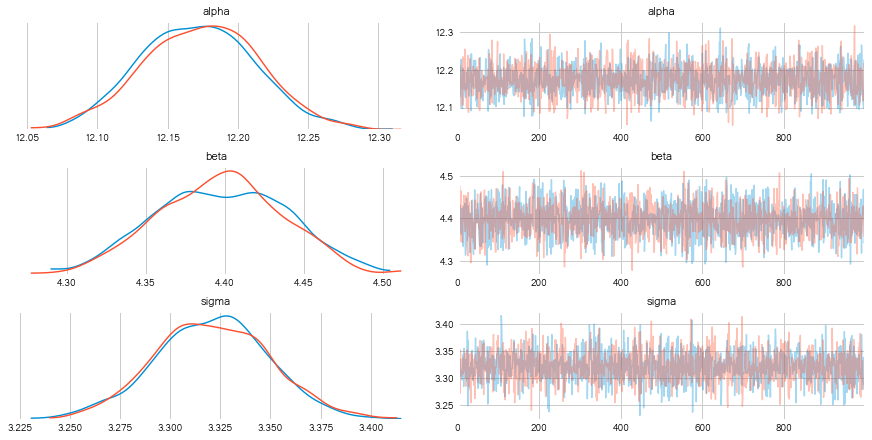

In [7]:
az.plot_trace(pm_data, backend="matplotlib")
plt.show()

On the left, we see the estimated probability distribution for our parameters. On the right, we see how the samples trace through the distribution. The $y$-axes on the right are the same as the $x$-axes on the left. The $x$-axes on the right are the sample number.


So what do we need to look out for when checking these trace plots? In short, any non-random looking patterns. These trace plots actually look all good, so it's probably best to show a few examples that fail. Sometimes the best way to understand something is trying to break it.


Go play around with this model and try to make it fail!

For most fails, you will also see warnings by PyMC. Another sign that something is wrong with your model is if the sampling process takes very long. This is a relatively simple model with not too much data, so it shouldn't take more than a few seconds.

Some hints on what to try:
- make the priors really really narrow
- use priors with hard boundaries (e.g. Uniform) on a wrong range, e.g. a negative range for beta
- use almost no tuning steps, e.g. `tune=10`
- use a very small amount of samples, e.g. `draws=100`

In [8]:
with pm.Model() as failed_mod:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=5)
    
    sigma = pm.HalfNormal("sigma", sigma=5)
    
    mu = alpha + beta*berlin["livingSpace_s"]
    
    rent = pm.Normal("rent", mu=mu, sigma=sigma,
                    observed = berlin["totalRent_s"])
    
    failed_trace = pm.sample(draws=100, tune=100)
    
failed_data = az.from_pymc3(trace = failed_trace, model = failed_mod)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 400/400 [00:00<00:00, 536.08draws/s]
The acceptance probability does not match the target. It is 0.9295898920608431, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9082388358185012, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


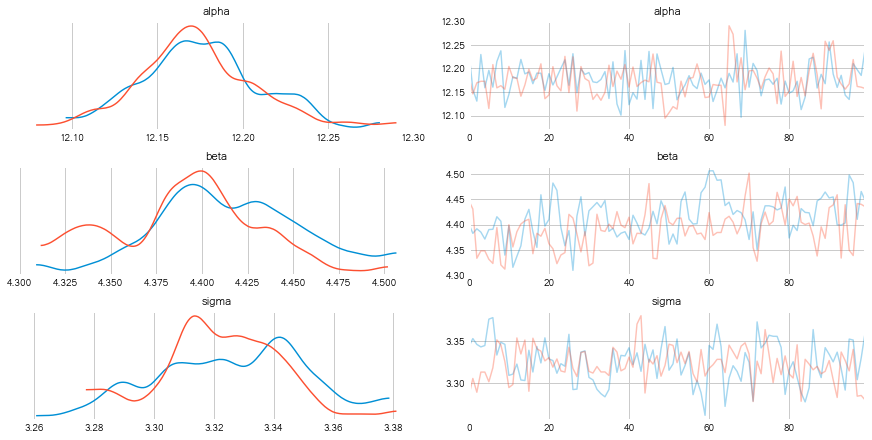

In [9]:
az.plot_trace(failed_data)
plt.show()

The next thing to check after the trace plots are the summary statistics.
In particular, there are
- ESS, effective sample size, the estimated number of samples
- R_hat, a diagnostic that compares the different chains
- MCSE, the Monte Carlo Standard Error

__ESS:__ As we're consecutively sampling from the probability space, sample $n$ is often slightly auto-correlated to sample $n-1$ and sample $n+1$. For this reason, the final sample cannot be treated as a completely independent sample from our target probability distribution, the posterior. ESS estimates how many _effective_ samples we have. If everything worked fine, this should be close to the actual number of samples. If it is much lower then there might be a problem with your model. This model is a very simple one and NUTS, the algorithm used by PyMC3 is very effective, so the effective number of samples is even higher than the actual number of samples!

__R_hat:__ The R_hat diagnostic checks if the different chains converged to the same value. This diagnostic should be very close to 1, definitely smaller than 1.05, some argue even smaller than 1.005, everything larger indicates a problem.

__MCSE:__ The Monte Carlo Standard Error is calculated as the standard deviation of the sample divided by the square root of ESS. The smaller the MCSE, the closer our estimates are expected to be to the true values.

We can check these values with ArviZ:

In [10]:
az.summary(pm_data, round_to=3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,12.173,0.041,12.096,12.249,0.001,0.001,2801.067,2800.063,2817.891,1398.770,1.001
beta,4.398,0.041,4.324,4.472,0.001,0.001,2785.615,2780.238,2736.599,1469.449,1.005
sigma,3.321,0.029,3.264,3.371,0.001,0.000,2286.250,2282.721,2281.414,1447.490,1.000


For this model, all summary and diagnostic statistics look good: the MCSE is very small, close to 0, the ESS is even larger than the actual number of samples and R_hat is very close to 1. Good!

In the same summary, we can also see the point estimates for the three parameters in the column `mean`. The estimates for alpha and beta should be very close to the coefficients we would get from `sklearn.linear_model.LinearRegression()` (feel free to try this out).

HPD is the highest probability density, so that 94% of probability mass is between hpd_3% and hpd_97%.

Let's have a look at some visualizations of the results

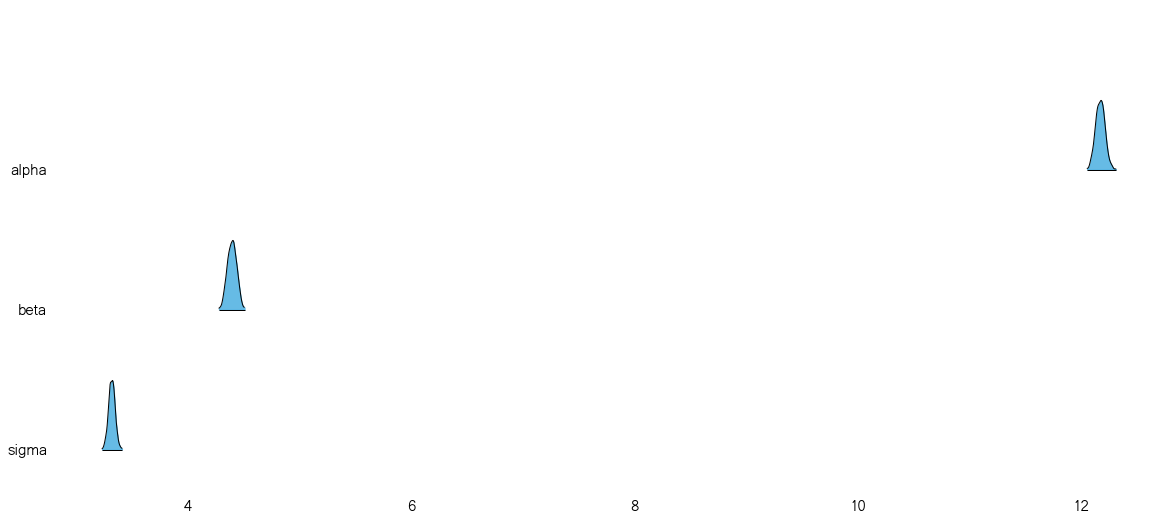

In [13]:
fig, ax = plt.subplots(figsize=(20, 9))
az.plot_forest(pm_data,
              # combine the different chains
              combined=True,
              kind="ridgeplot", ridgeplot_alpha=0.6, 
              linewidth=1,
              ax=ax)
plt.show()

Or we can visualize the resulting model as before, this time not using the prior but the posterior, that is the trace object:

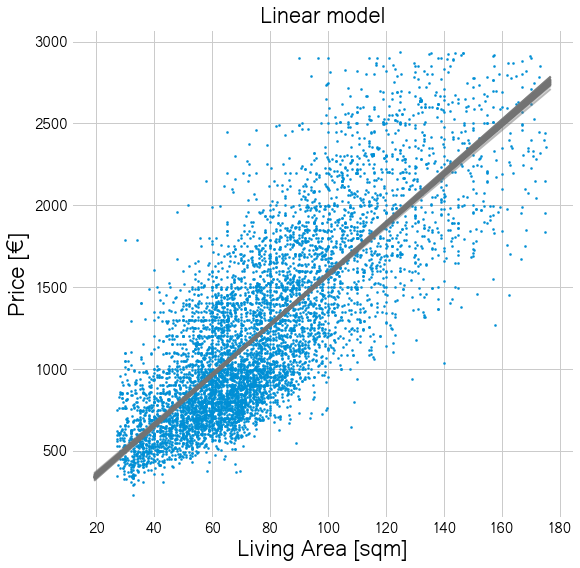

In [14]:
from utils import draw_models

draw_models(trace, berlin)
plt.scatter(berlin["livingSpace"], berlin["totalRent_s"]*100, s=4)
plt.title("Linear model")
plt.show()

Instead of drawing a few sample lines from the model, we can also compute mu for each sample and use ArviZ to plot credibility intervals (hpd intervals):

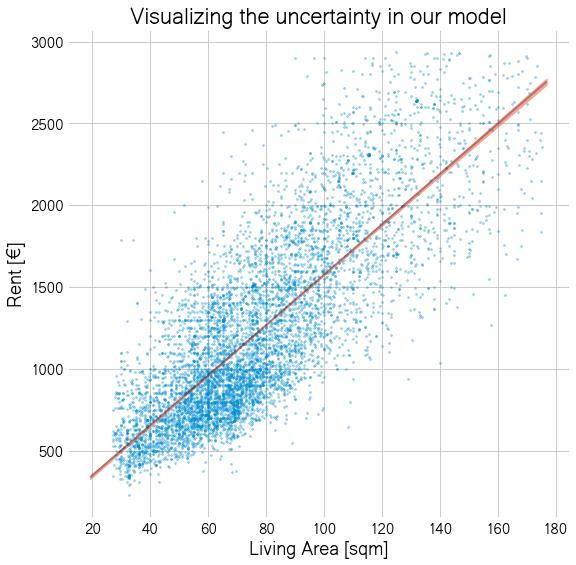

In [15]:
area_s = np.linspace(start=-2, stop=3.5, num=50)

mu_pred = trace['alpha'] + trace['beta'] * area_s[:,None]

# destandardize area again
area = destandardize_area(area_s)

plt.plot(area, mu_pred.mean(1)*100, alpha=0.3, c="k")
plt.scatter(berlin["livingSpace"], berlin["totalRent_s"]*100, s=4, alpha=0.4)

az.plot_hpd(area, mu_pred.T*100, credible_interval=0.83)




plt.xlabel('Living Area [sqm]')
plt.ylabel('Rent [€]')
plt.title('Visualizing the uncertainty in our model')
plt.show()

Our model is actually very certain about where the mu is. This makes sense, because we have quite a bit of data for this relatively simple model.

But this is not all the uncertainty our model is aware of. We also have the estimate sigma that tells us how far the rent could be away from this mean mu. We can compute the predicted ranges for rent as follows:

In [84]:
import scipy.stats as stats

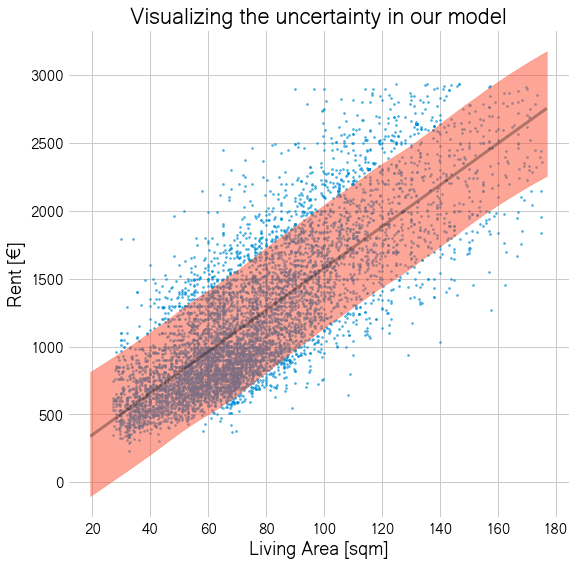

In [123]:
rent_pred = stats.norm.rvs(mu_pred, trace['sigma'])

plt.plot(area, mu_pred.mean(1)*100, alpha=0.3, c="k")
plt.scatter(berlin["livingSpace"], berlin["totalRent_s"]*100, s=4, alpha=0.7)

az.plot_hpd(area, rent_pred.T*100, credible_interval=0.83, 
            fill_kwargs={"alpha": 0.5})



plt.xlabel('Living Area [sqm]')
plt.ylabel('Rent [€]')
plt.title('Visualizing the uncertainty in our model')
plt.show()

The red area should now contain around 83% of our data if the model is good.

The same way as we computed the `mu_pred` and `rent_pred`, we could also predict the rent price for a new flat. 

Can you predict the rent price for example for your own flat?

In [ ]:
area_of_my_own_flat = []

# don't forget to standardize
area_of_my_own_flat_s = ...

There is also a less manual way to get predictions on new data. Unfortunately, it is not as straight-forward as with scikit-learn. You will need to set up the predictor variables used inside the model as a data container:

In [16]:
with pm.Model() as mod:
    # create data containers for predictor variable
    area = pm.Data("area", berlin["livingSpace_s"])
    
    # rest stays the same
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=5)
    
    sigma = pm.HalfNormal("sigma", sigma=5)
    
    mu = alpha + beta*area
    
    rent = pm.Normal("rent", mu=mu, sigma=sigma,
                    observed = berlin["totalRent_s"])
    
    trace = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 940.06draws/s] 


We can then swap the content of this data container with new data and then compute the prediction for the new data:

In [19]:
# unfortunately there is an issue that predicting a single obs
# doesn't work correctly https://github.com/pymc-devs/pymc3/issues/3640#issuecomment-563897443
# so just use two
new_area = standardize_area([74, 97])
with mod:
    pm.set_data({"area": new_area})
    
    post_pred = pm.sample_posterior_predictive(trace, samples=1000)

/home/corrie/.local/share/virtualenvs/PyLadies-Bayesian-Tutorial-HLPPdyhP/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:13<00:00, 74.60it/s]


At first, it might look unhandy and more difficult to work with samples as predictions instead of point estimates. While indeed this means we often need to handle multidimensional arrays, the advantage of this is that we can see the whole probability distribution over rents for one flat.

Plot the histogram over rents for the first flat!
(Don't forget to destandardize the rent price again!)

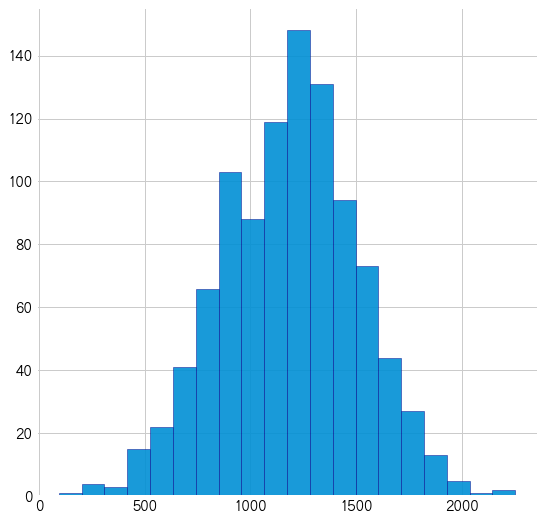

In [22]:
plt.hist(post_pred["rent"][:,0]*100, alpha=0.9, ec="darkblue", bins=20)
plt.show()

The sample also allows it to answer questions such as, how likely is it that the rent of this flat would be below 600€. 

For this, we check how many points in our samples are smaller than 600€ and then take the mean of the vector:

In [23]:
np.mean(post_pred["rent"]*100 < 600)

0.0205

Cool, eh? (Though the result is maybe a bit depressing...)